# VARIMA

In this notebook, I explore the VARMAX, a part of the "statsmodels" library.
https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html

In [96]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VARMAX
from sklearn.metrics import mean_squared_error

In [68]:
#data set from kaggle: https://www.kaggle.com/competitions/grupo-bimbo-inventory-demand/data

# load train.csv
data_path = "..\product-inventory"
filename = os.path.join(data_path, "grupo-bimbo-inventory-demand/train.csv.zip")

train = pd.read_csv(filename, 
                 usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil'])

# rename columns
train = train.rename(columns={  'Semana': 'Week_num',
                                'Cliente_ID': 'Client_ID',
                                'Demanda_uni_equil': 'adjusted_demand',
                                'Producto_ID': 'Product_ID'})
# define client-product ID
train['ID'] = train.groupby(['Client_ID', 'Product_ID']).ngroup()
unique_ids = train['ID'].unique()

# Define the fraction of IDs to sample
fraction = 0.01  # sample 1% of the IDs

# Calculate the number of IDs to sample
sample_size = int(len(unique_ids) * fraction)

# Choose a random sample of IDs
sampled_ids = np.random.choice(unique_ids, size=sample_size, replace=False)

# Filter the DataFrame to keep all rows with the sampled IDs
train = train[train['ID'].isin(sampled_ids)].reset_index()

print(len(train))

# calculate price
# train['Price'] = train['sales_this_week']/train['sales_unit_this_week']
# train['log_price'] = np.log(train['Price'])

# dependent variable
# train['log_adj_demand'] = np.log(train['adjusted_demand'])

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\amirh\AppData\Local\Temp\ipykernel_20616\1001510194.py:4: SyntaxWarning: invalid escape sequence '\p'
  data_path = "..\product-inventory"


741159


In [ ]:
train = train.groupby(['Client_ID', 'Week_num', 'Product_ID'], as_index=False).agg({'adjusted_demand': 'sum'})
# print("Number of Different Products:", train['Product_ID'].value_counts())
# print("Number of Unique Clients:", len(train['Client_ID'].unique()))
# print("Number of Unique Weeks:", len(train['Week_num'].unique()))
# train = train[train['Product_ID'] <= 1284]
# print("Number of Different Products:", train['Product_ID'].value_counts())
# df = train.pivot(columns = ['Product_ID'], index=['Week_num', 'Client_ID'], values = 'adjusted_demand')
# df = df.fillna(0)
# df = df.reset_index()
# df.head(10)

In [ ]:
# clients = train['Client_ID'].unique()
# for client in clients:
client_data = train[train['Client_ID'] == 3373]
client_data = client_data.pivot(columns = 'Product_ID', index='Week_num', values = 'adjusted_demand')
client_data = client_data.fillna(0)

print(client_data.dtypes)
# client_data[43341] = client_data[43341].astype('float64')  # Convert a column to float64

model = VARMAX(client_data, order=(1, 0))  # (p, q) orders
results = model.fit()
print(results.summary())
forecast = results.get_forecast(steps=4)
forecast_df = forecast.predicted_mean
print("\nPooled Forecast:")
print(forecast_df)




Product_ID
1284     float64
46772    float64
dtype: object


c:\Users\amirh\.julia\conda\3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                           Statespace Model Results                           
Dep. Variable:          [1284, 46772]   No. Observations:                    5
Model:                         VAR(1)   Log Likelihood                 -23.666
                          + intercept   AIC                             65.331
Date:                Thu, 27 Mar 2025   BIC                             61.816
Time:                        11:34:27   HQIC                            55.897
Sample:                             0                                         
                                  - 5                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             2.14, 0.06   Jarque-Bera (JB):           0.31, 0.42
Prob(Q):                        0.14, 0.81   Prob(JB):                   0.86, 0.81
Heteroskedasticity (H):        45.84, 0.44   Skew:                      -0.56, 0.68
Prob(H) (two-sided):            0.04,

c:\Users\amirh\.julia\conda\3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\amirh\.julia\conda\3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\amirh\.julia\conda\3\envs\erdos_spring_2025\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


**How many firms' demand one product and how many demand more than one product?**

If the majority of firms demand only one product, using VARIMA is not sensible. As shown below, 80 percent of firms demand one product which means that VARIMA is not helpful (possible) in improving our prediction.

(array([0.80056347, 0.96583186, 0.96583186, 0.99467248, 0.99467248,
        0.99923687, 0.99989921, 0.99989921, 0.9999952 , 1.        ]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

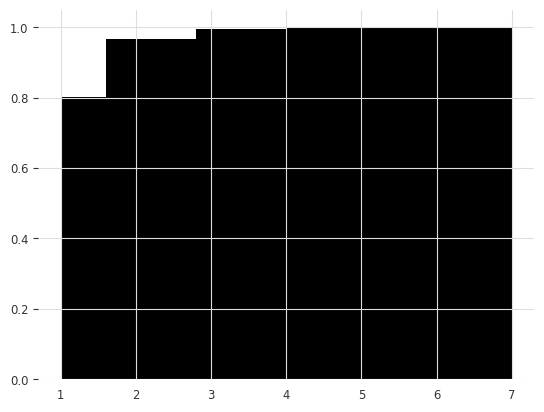

In [107]:
client_product = train.groupby('Client_ID').agg({'Product_ID': 'nunique'})

plt.hist(client_product['Product_ID'], cumulative=True, density=True)